In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data = pd.read_csv('../preprocessed_all_countries_combined_comments.csv')

In [3]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['body'].apply(lambda x:len(str(x).split())) 

In [4]:
print('Info about training data:')
print(train_data['label'].value_counts())
print('Total comments: ', len(train_data))

# will be used for sequence
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
positive    5961
negative    3260
neutral     1947
Name: label, dtype: int64
Total comments:  11168


In [5]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :819


In [6]:
# consider 11k comments
num_words = 11168

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['body'].values.astype(str).tolist())

In [7]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['body'],\
                                                      train_data['label'],\
                                                      test_size=0.3,\
                                                      random_state=0)

In [8]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

#x_train = tokenizer.texts_to_matrix(X_train.values.astype(str))
#x_test  = tokenizer.texts_to_matrix(X_test.values.astype(str))

<ipython-input-8-3ebf70ccd52a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-8-3ebf70ccd52a>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [9]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 819.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [10]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['negative', 'neutral', 'positive']

In [11]:
# looking for top 10k comments
max_features = 11168

#every index is represented by 32 dimensional vector
embedding_dim = 32

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   #embeddings_regularizer = regularizers.l2(0.0005)
                                   )) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [12]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 10,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
245/245 [==============================] - 3s 9ms/step - loss: 0.9732 - accuracy: 0.5228 - auc: 0.6941 - val_loss: 0.8697 - val_accuracy: 0.5897 - val_auc: 0.7729
Epoch 2/10
245/245 [==============================] - 1s 5ms/step - loss: 0.6938 - accuracy: 0.6712 - auc: 0.8577 - val_loss: 0.6432 - val_accuracy: 0.7493 - val_auc: 0.8969
Epoch 3/10
245/245 [==============================] - 1s 5ms/step - loss: 0.1616 - accuracy: 0.9520 - auc: 0.9936 - val_loss: 0.8246 - val_accuracy: 0.7747 - val_auc: 0.9005
Epoch 4/10
245/245 [==============================] - 1s 5ms/step - loss: 0.0285 - accuracy: 0.9951 - auc: 0.9997 - val_loss: 0.9396 - val_accuracy: 0.7833 - val_auc: 0.9069
Epoch 5/10
245/245 [==============================] - 1s 5ms/step - loss: 0.0067 - accuracy: 0.9992 - auc: 0.9997 - val_loss: 1.1015 - val_accuracy: 0.7956 - val_auc: 0.9018


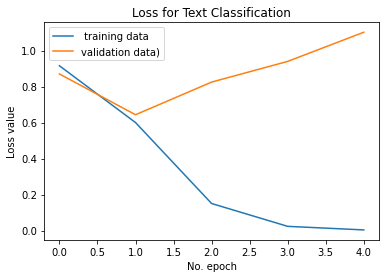

In [13]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

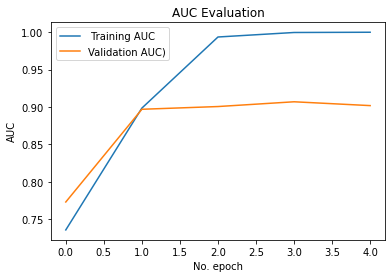

In [14]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [15]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-15-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [16]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples


array([2, 2, 2, ..., 2, 2, 0], dtype=int64)

In [17]:
y_pred = np.where((y_pred == 0),'negative', y_pred)
y_pred = np.where((y_pred == '1'),'neutral', y_pred)
y_pred = np.where((y_pred == '2'),'positive', y_pred)

In [18]:
labels = ['positive', 'negative','neutral']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.75      0.67      0.71       946
     neutral       0.81      0.71      0.76       605
    positive       0.81      0.89      0.85      1800

    accuracy                           0.80      3351
   macro avg       0.79      0.76      0.77      3351
weighted avg       0.79      0.80      0.79      3351

